# 1. 오차 역전파법에 대해
모델을 경사하강법을 통해 손실 함수의 최솟값을 찾으며 학습 시키는데, 그때 기울기를 찾는 방법은 수치미분법과 오차역전파법이 있다.

## 오차 역전파법
 - 수치미분법과 비교해서 압도적으로 속도가 빠르다.
 
 - 각 단계에서 입력값에 대해 미분을 하며 역전파 방향에서는 최종 결과값 z는 dz/dz, 각 역방향에서는 그 전 미분값을 가져온다.

- x -> y -> z 이면 dy/dx, dz/dy, dz/dz 이고 z에서부터 전달하면 최종적으로 dy/dz x dz/dy x dz/dz 이고 결국 dz/dx로 z의 변화량/x의 변화량이다.
 x가 n만큼 변하면 최종 결과값 z가 ?만큼 변하는지 알 수 있다.


In [39]:
# 덧셈의 역전파는 입력된 값을 그대로 다음 노드로 보낸다. 
# z = x + y
# dz/dx = 1(x 미분, y는 상수취급 미분되어서 0), dz/dy = 1(y 미분, x 역시 미분되서 0)

class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y): # 덧셈은 그대로 더해서 다음 층으로 간다.
    out = x + y
    return out

  def backward(self, dout): # 덧셈 역전은 E * 미분값이므로 결과값 그대로 역전
    dx = dout * 1
    dy = dout * 1
    return dx, dy

# 곱셈의 역전파는 
# z = xy
# dz/dx = y(x에 대해서 미분, x 미분되서 1되서 1 * y = y), dz/dy = x (편미분 동일)
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y): # 곱셈은 다음 층으로 곱셈 결과 넘어감
    self.x = x
    self.y = y
    out = x*y

    return out

  def backward(self, dout): # 역전 역시 E * 미분값이므로 dx에는 결과값 * 미분값 y, dy에는 결과값 * 미분값 x가 전달된다.
    dx = dout * y
    dy = dout * x

    return dx, dy

In [40]:
#inputs
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

#layers
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

#forward propagation
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

#back propagation
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange_num, dorange, dtax)

NameError: ignored

# MNIST 데이터를 통한 딥러닝 실습
## 이미지 분류기 실습

1. torchvision을 이용해서 학습/시험용 데이터셋을 불러오고, 정규화를 한다.

2. layer를 정의한다.

3. 손실 함수를 정의한다.

4. 학습용 데이터를 사용해서 학습하고, 시험용 데이터를 통해 검사한다.

단계 하나하나는 어떤 식으로 진행이 되는지 이해는 되지만, 코드 자체는 아직 익숙치 않아서 코드를 안 보고 치기는 어렵다.

각 단계에 사용되는 메소드는 어떤 역할을 하는지 구글링을 해서 어떤 흐름인지 이해를 하는 식으로 실습을 진행했다.

In [2]:
!pip3 install torch torchvision

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [5]:
# 데이터 전처리 진행
# ToTensor()는 scaling (데이터의 scale을 줄여줌)
# Normalize()는 cenering + scaling (scale을 줄이고 데이터의 중심을 원점으로 맞춰주는 것)
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                # numpy 이미지에서 torch 이미지로 변경
                                transforms.Normalize((0.5,),(0.5,))
                                # ToTensor()로 타입 변경시 0~1 사이의 값으로 변경
                                # normalize를 이용해서 -1 ~ 1 사이의 값으로 정규화 
                                ])

training_dataset = datasets.MNIST(root='./data', train=True, download = True, transform = transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()# tensor 복사 후 numpy()
  image = image.transpose(1,2,0) # i,j,k -> j,k,i로 transpose
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1) # 0보다 작은 값은 0으로, 1보다 큰 값들은 1으로
  return image

  # tensor란 데이터의 배열
  # tensor를 numpy로 변환하는 함수 

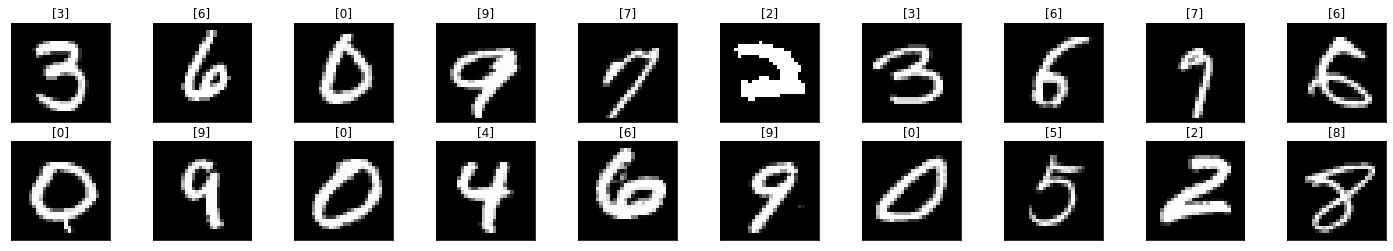

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [11]:
class Classifier(nn.Module):

  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
    # model = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x
    #활성화 함수는 relu 함수를 이용
    # x <= 0일시 0, x >0 일시 x

In [12]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
# 다중분류를 위한 대표적인 손실함수
# 회귀에서는 보통 MSE가 쓰인다.
# nn.LogSoftmax(softmax함수의 결과에 log) + nn.NLLLoss 연산의 조합
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# 최적화 Adam 사용

In [14]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: # 100장씩 사진 input
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs) # 100장 입력, 100장 출력, forward
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward() # 역전파
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9326, acc 77.2550 
validation loss: 0.4111, validation acc 88.9100 
epoch : 2
training loss: 0.3704, acc 89.6267 
validation loss: 0.3199, validation acc 90.9600 
epoch : 3
training loss: 0.3076, acc 91.1150 
validation loss: 0.2759, validation acc 92.3200 
epoch : 4
training loss: 0.2739, acc 92.0800 
validation loss: 0.2495, validation acc 92.8700 
epoch : 5
training loss: 0.2508, acc 92.7050 
validation loss: 0.2303, validation acc 93.4200 
epoch : 6
training loss: 0.2296, acc 93.4300 
validation loss: 0.2144, validation acc 93.7000 
epoch : 7
training loss: 0.2125, acc 93.8500 
validation loss: 0.2046, validation acc 94.0400 
epoch : 8
training loss: 0.1976, acc 94.2567 
validation loss: 0.1912, validation acc 94.4500 
epoch : 9
training loss: 0.1853, acc 94.6200 
validation loss: 0.1872, validation acc 94.4700 
epoch : 10
training loss: 0.1736, acc 94.9750 
validation loss: 0.1699, validation acc 95.0800 
epoch : 11
training loss: 0.1633, acc 95.2417 
va

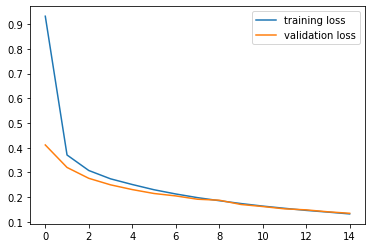

In [15]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

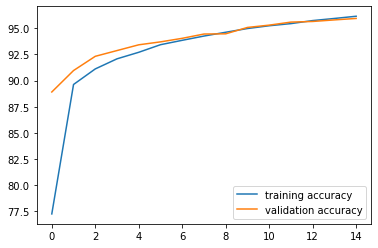

In [16]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()